In [5]:
import matplotlib.pyplot as plt
from scipy.linalg import sqrtm, inv
import numpy as np

In [82]:
# Implements BWDG over a stochastic Subspace 
def bwgd_subspace(y, A, r, eta = 1, niter = 1000):
    d, n = A.shape 
    x = np.zeros((niter, d))  
    x[0] = np.random.randn(d)

    # Covariance matrix transform
    C = A @ A.T / n
    C_sqrt = sqrtm(C)
    C_inv = np.real(inv(C_sqrt))
    A_tilde = C_inv @ A 
    x_tilde = C_sqrt @ x[0]

    # Descent
    for iter in range(1, niter):
        # Subspace
        S,_ = np.linalg.qr(np.random.normal(size = (d, r)))
        P = S @ S.T              # Projection onto S
        Q = (np.eye(d) - eta * P)    # Projection onto S_perp
        
        # Descent
        sum_gradient = A_tilde @ (np.sqrt(y) * (A_tilde.T @ x_tilde) / np.abs(A_tilde.T @ x_tilde))
        x_tilde = Q @ x_tilde + (eta / n) * P @ sum_gradient

        x[iter] = C_inv @ x_tilde

        if np.linalg.norm(x[iter] - x[iter-1])<1e-11:
                return x[:iter]
        
    return x

In [53]:
# Take minimum error for all positive and negative x
def min_error(x_hat, x_star):
    errors = []
    for x in x_hat:
            error_positive = np.linalg.norm(x_star - x)
            error_negative = np.linalg.norm(-1*x_star - x)
            errors.append(min(error_positive, error_negative))
    return errors

# Returns the convergence count for errors for a set of test parameters
def convergence_counts(errors, parameter, error_threshold = 1e-11):
    zero_error = {}
    for i in range(len(errors)):
        zero_error[parameter[i]] = 0
        for error in errors[i]:
            zero_error[parameter[i]] += error[-1] < error_threshold
    return zero_error

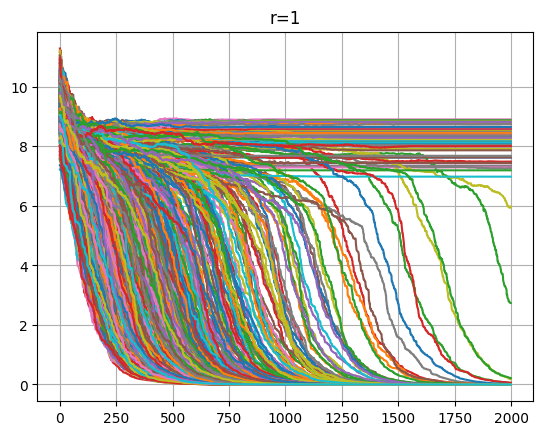

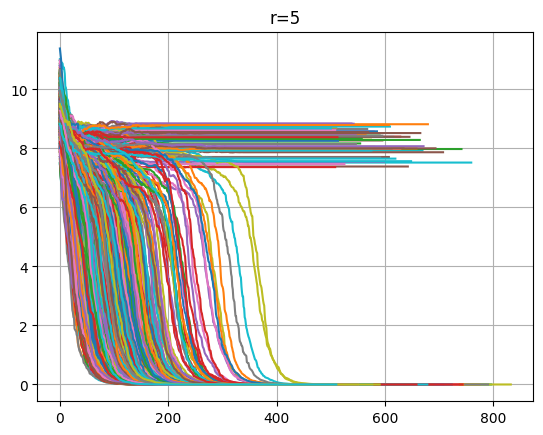

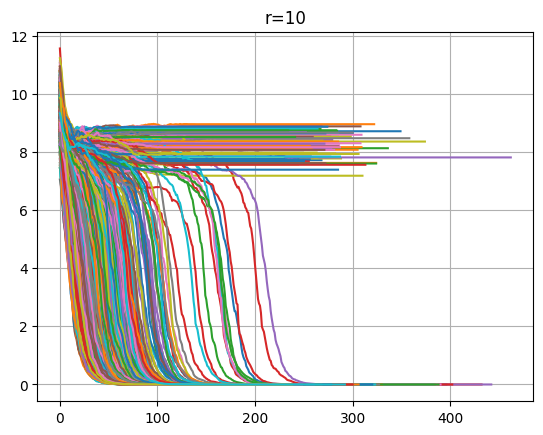

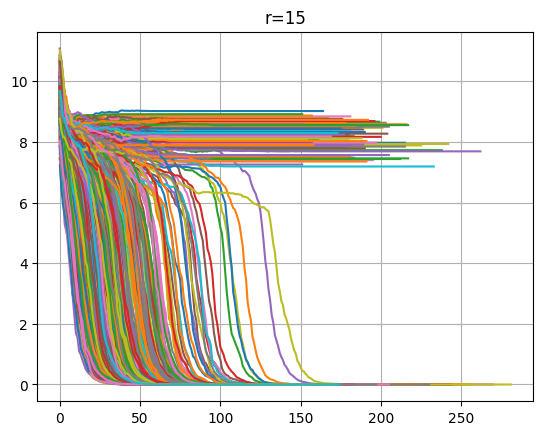

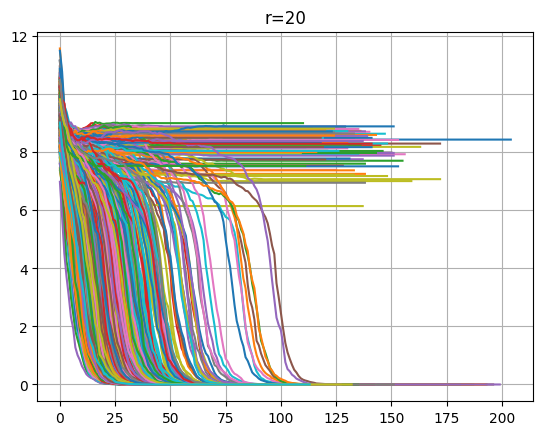

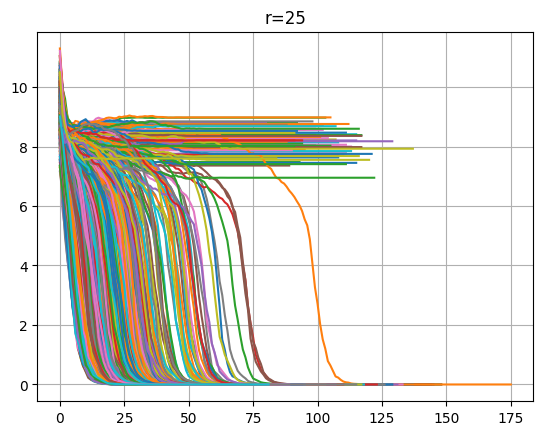

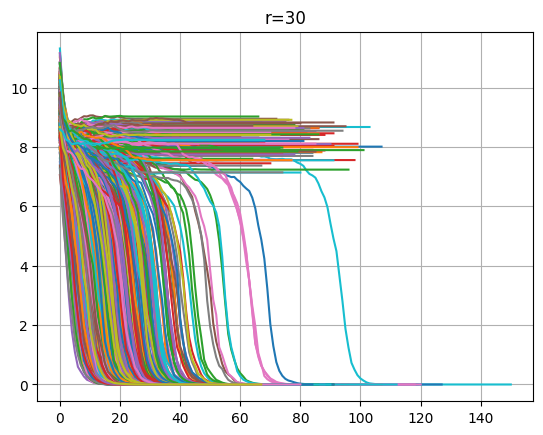

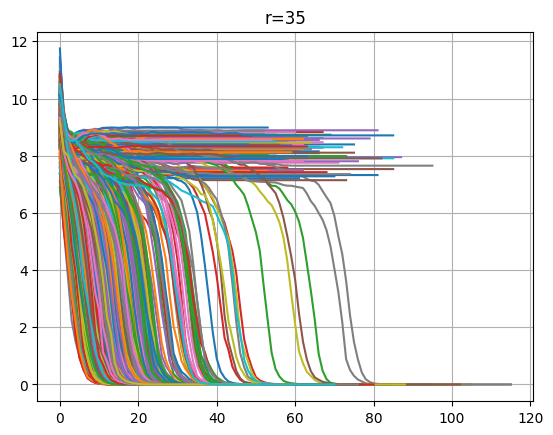

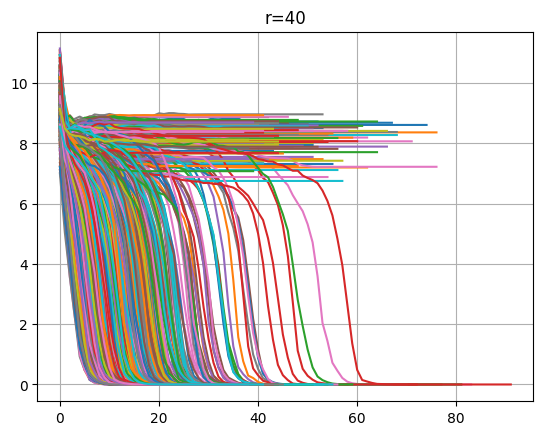

In [92]:
n = 1000
d = 50
errors = []
r_vals =  [1, 5, 10, 15, 20, 25, 30, 35, 40]

for r in r_vals:
    r_error = []
    for j in range(1, 1001):  
        # Generate vectors
        x = np.ones(d)
        A = np.random.randn(d, n)
        y = np.square(A.T @ x)
        
        # Run the algorithm
        x_hat = bwgd_subspace(y, A, r, niter = 2000)

        error = min_error(x_hat, x)
        r_error.append(error)
        
        # Plot results
        plt.plot(error)

    errors.append(r_error)

    plt.title(f'r={r}')
    plt.grid(True)
    plt.show()

In [123]:
convergence_counts(errors, r_vals, error_threshold = 1e-9)

{1: 0, 5: 939, 10: 918, 15: 912, 20: 902, 25: 927, 30: 910, 35: 905, 40: 890}

Use subspace method with thresholding

In [136]:
# Discards the smallest alpha% samples at every iteration
def bwgd_subspace_threshold(y, A, r, alpha, eta = 1, niter = 1000):
    d, n = A.shape  
    x = np.zeros((niter, d))  
    x[0] = np.random.randn(d)
    threshold = int(alpha * n)

    # Descent
    for iter in range(1, niter):
        # Find indices for smallest |AtX|
        sorted_indices = np.argsort(np.abs(A.T @ x[iter - 1]))
        indices = sorted_indices[threshold:]

        # Discard the selected indices
        A_filtered = A.T[indices].T.copy()
        y_filtered = y[indices].copy()

        # Covariance matrix transform
        C = A_filtered @ A_filtered.T / n
        C_sqrt = sqrtm(C)
        C_inv = np.real(inv(C_sqrt))
        A_tilde = C_inv @ A_filtered 
        x_tilde = C_sqrt @ x[iter - 1]

        # Subspace
        S,_ = np.linalg.qr(np.random.normal(size = (d, r)))
        P = S @ S.T              # Projection onto S
        Q = (np.eye(d) - eta * P)    # Projection onto S_perp

        # Descent
        sum_gradient = A_tilde @ (np.sqrt(y_filtered) * (A_tilde.T @ x_tilde) / np.abs(A_tilde.T @ x_tilde))
        x_tilde = Q @ x_tilde + (eta / n) * P @ sum_gradient

        x[iter] = C_inv @ x_tilde

        if np.linalg.norm(x[iter] - x[iter-1])<1e-11:
            return x[:iter]
        
    return x

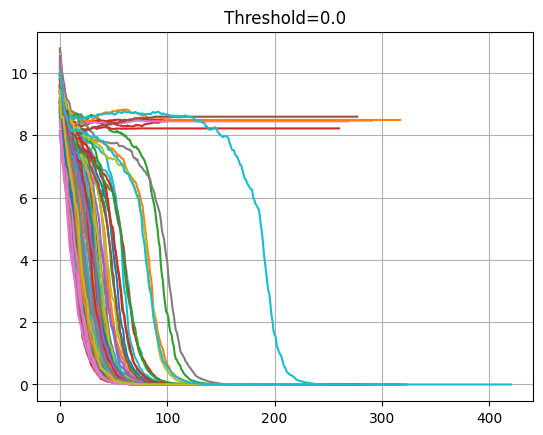

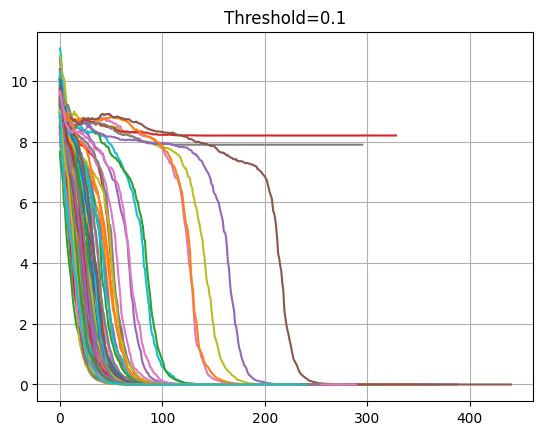

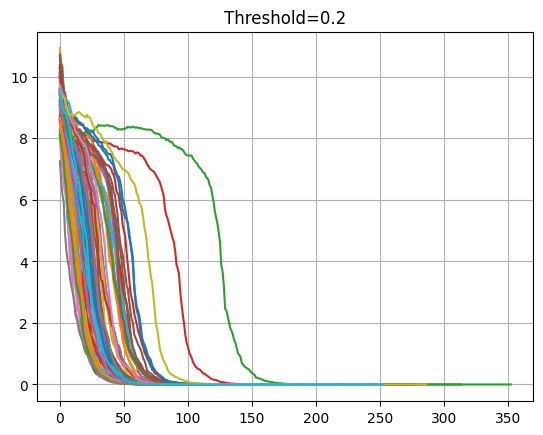

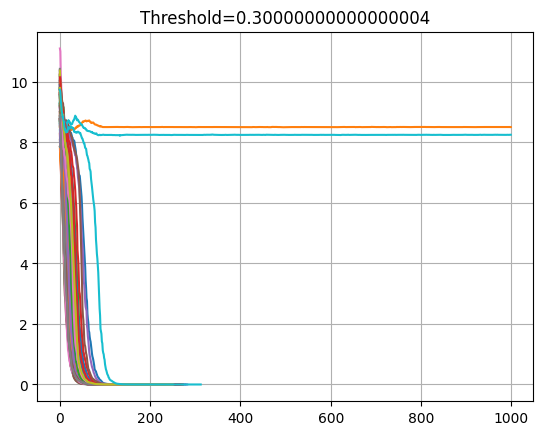

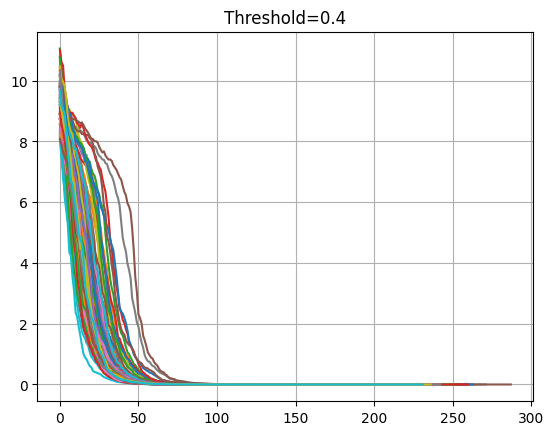

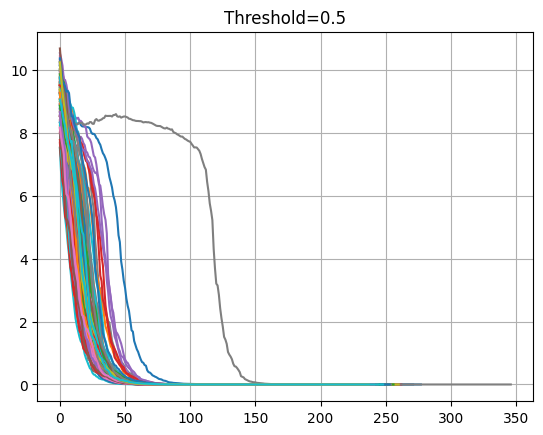

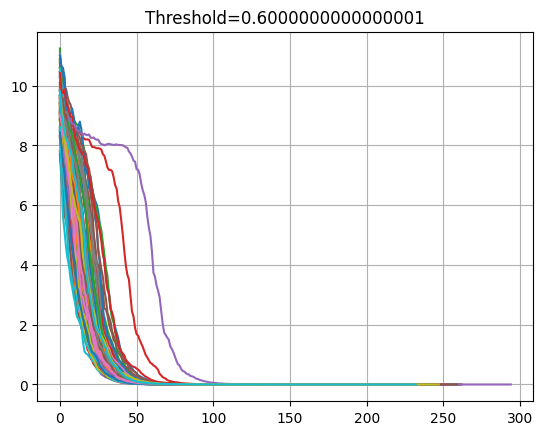

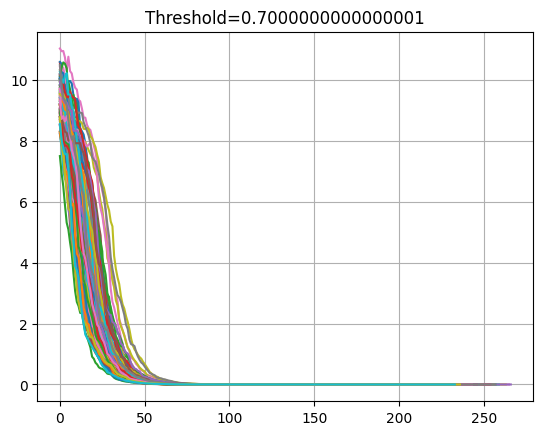

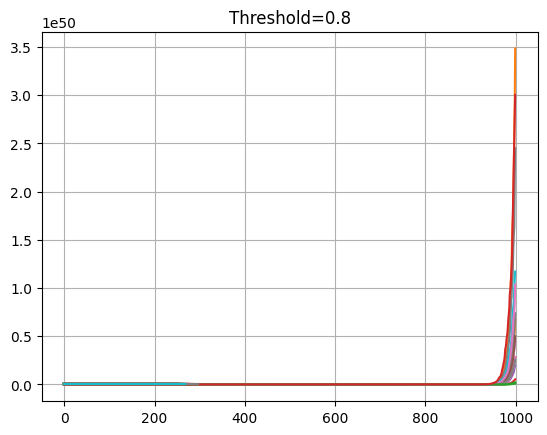

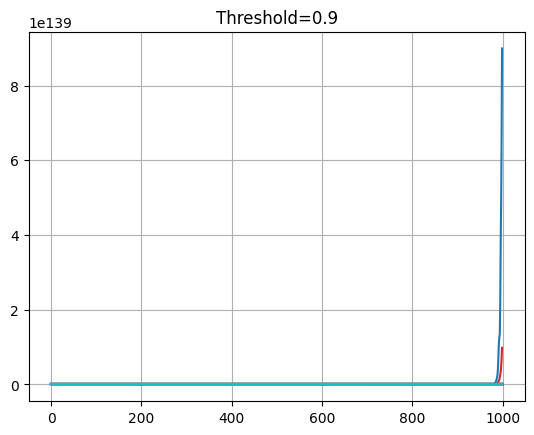

{0.0: 0,
 0.1: 0,
 0.2: 0,
 0.30000000000000004: 0,
 0.4: 0,
 0.5: 0,
 0.6000000000000001: 0,
 0.7000000000000001: 0,
 0.8: 0,
 0.9: 0}

In [87]:
n = 1000
d = 50
errors = []
thresholds =  np.arange(0, 10)*0.1

for threshold in thresholds:
    threshold_error = []
    for j in range(1, 101):  
        # Generate vectors
        x = np.ones(d)
        A = np.random.randn(d, n)
        y = np.square(A.T @ x)
        
        # Run the algorithm
        x_hat = bwgd_subspace_threshold(y, A, 10, threshold)

        error = min_error(x_hat, x)
        threshold_error.append(error)
        
        # Plot results
        plt.plot(error)

    errors.append(threshold_error)

    plt.title(f'Threshold={threshold}')
    plt.grid(True)
    plt.show()

**Phase Transitions**

r vs threshold

In [188]:
from tqdm import tqdm
def phase_transition(X, Y, n=1000, error_threshold = 1e-9, niter = 100):
    # Matrix for convergence in samples x alphas
    convergence = np.zeros((len(X), len(Y)))
    
    # Define values
    d = 50
    x_true = np.ones(d)
    
    for i, r in tqdm(enumerate(X)):
        for j, alpha in enumerate(Y):
            converged = 0
            for _ in range(niter):
                # Generate random samples A and response y
                A = np.random.randn(d, n)
                y = (A.T @ x_true)**2  
                
                # Run algorithm
                x_hat = bwgd_subspace_threshold(y, A, r=r, alpha=alpha)

                # Check for convergence
                if min_error(x_hat, x_true)[-1] < error_threshold:
                    converged += 1 

            convergence[i, j] = converged
            
    return convergence

In [189]:
r_vals =  [5, 10, 15, 20, 25, 30, 35, 40, 45, 50]
alphas = np.arange(0, 10) * 0.1  

convergence_1000_samples = phase_transition(r_vals, alphas, 1e-9)

array([[ 92.,  99.,  99.,  99., 100., 100., 100., 100.,  48.,   0.],
       [ 94.,  98., 100., 100., 100., 100., 100., 100.,  79.,   0.],
       [ 88.,  99., 100.,  97.,  99., 100., 100., 100.,  95.,   0.],
       [ 92.,  99.,  99.,  99., 100., 100., 100., 100., 100.,   0.],
       [ 85.,  97.,  99., 100., 100., 100., 100., 100., 100.,   0.],
       [ 88.,  99.,  99.,  99.,  97., 100., 100., 100., 100.,   3.],
       [ 93.,  95., 100.,  97., 100., 100., 100., 100., 100.,  37.],
       [ 90.,  96.,  99., 100., 100., 100., 100., 100., 100.,  98.],
       [ 90.,  97., 100., 100., 100., 100., 100., 100., 100., 100.],
       [ 95.,  98.,  99., 100., 100., 100., 100., 100., 100., 100.]])

Text(0.5, 1.0, 'Alpha v r, samples = 1000')

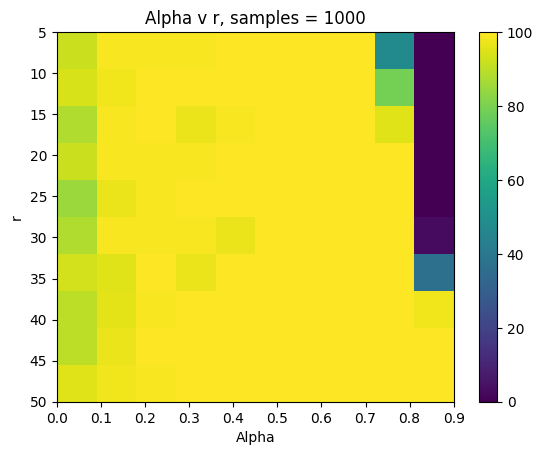

In [185]:
im = plt.imshow(convergence_1000_samples, extent=[alphas[0], alphas[-1], r_vals[-1], r_vals[0]], aspect='auto')
plt.colorbar()
plt.xlabel('Alpha')
plt.ylabel('r')
plt.title('Alpha v r, samples = 1000')

In [193]:
r_vals =  [5, 10, 15, 20, 25, 30, 35, 40, 45, 50]
alphas = np.arange(0, 10) * 0.1 
convergence_300_samples = phase_transition(r_vals, alphas, n=300)
convergence_300_samples

0it [00:00, ?it/s]C:\Users\gabreu\AppData\Local\Temp\ipykernel_24768\4245377890.py:34: ComplexWarning: Casting complex values to real discards the imaginary part
  x[iter] = C_inv @ x_tilde
C:\Users\gabreu\AppData\Local\Temp\ipykernel_24768\4245377890.py:34: RuntimeWarning: overflow encountered in matmul
  x[iter] = C_inv @ x_tilde
C:\Users\gabreu\AppData\Local\Temp\ipykernel_24768\4245377890.py:34: RuntimeWarning: invalid value encountered in matmul
  x[iter] = C_inv @ x_tilde
C:\Users\gabreu\AppData\Local\Temp\ipykernel_24768\4245377890.py:31: RuntimeWarning: invalid value encountered in divide
  sum_gradient = A_tilde @ (np.sqrt(y_filtered) * (A_tilde.T @ x_tilde) / np.abs(A_tilde.T @ x_tilde))
C:\Users\gabreu\AppData\Local\Temp\ipykernel_24768\4245377890.py:11: RuntimeWarning: invalid value encountered in matmul
  sorted_indices = np.argsort(np.abs(A.T @ x[iter - 1]))
C:\Users\gabreu\AppData\Local\Temp\ipykernel_24768\4245377890.py:23: RuntimeWarning: invalid value encountered in m

array([[ 21.,  43.,  48.,  74.,  79.,  82.,  93.,   0.,   0.,   0.],
       [  8.,  32.,  56.,  68.,  78.,  81.,  95.,   3.,   0.,   0.],
       [ 17.,  37.,  58.,  66.,  80.,  90.,  95.,  14.,   0.,   0.],
       [ 17.,  31.,  51.,  74.,  81.,  90.,  95.,  48.,   0.,   0.],
       [ 14.,  32.,  48.,  69.,  76.,  95.,  97.,  89.,   0.,   0.],
       [ 12.,  27.,  46.,  70.,  75.,  93.,  97.,  99.,   0.,   0.],
       [ 15.,  36.,  53.,  66.,  85.,  96.,  99.,  99.,   0.,   0.],
       [  9.,  36.,  54.,  70.,  76.,  94.,  94., 100.,   0.,   0.],
       [ 11.,  33.,  52.,  67.,  79.,  96.,  98.,  99.,  13.,   0.],
       [  8.,  35.,  50.,  60.,  67.,  75.,  93.,  87., 100.,   0.]])

Text(0.5, 1.0, 'Alpha v r, samples = 300')

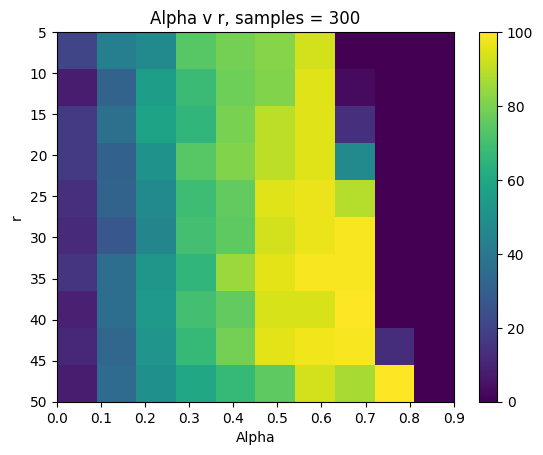

In [194]:
im = plt.imshow(convergence_300_samples, extent=[alphas[0], alphas[-1], r_vals[-1], r_vals[0]], aspect='auto')
plt.colorbar()
plt.xlabel('Alpha')
plt.ylabel('r')
plt.title('Alpha v r, samples = 300')

samples vs threshold

In [201]:
def phase_transition(X, Y, r=15, error_threshold = 1e-9, niter = 100):
    # Matrix for convergence in samples x alphas
    convergence = np.zeros((len(X), len(Y)))
    
    # Define values
    d = 50
    x_true = np.ones(d)
    
    for i, n in tqdm(enumerate(X)):
        for j, alpha in enumerate(Y):
            converged = 0
            for _ in range(niter):
                # Generate random samples A and response y
                A = np.random.randn(d, n)
                y = (A.T @ x_true)**2  
                
                # Run algorithm
                x_hat = bwgd_subspace_threshold(y, A, r=r, alpha=alpha, niter=300)

                # Check for convergence
                if min_error(x_hat, x_true)[-1] < error_threshold:
                    converged += 1 

            convergence[i, j] = converged
            
    return convergence

In [ ]:
samples = np.arange(100, 1100, 100) 
alphas = np.arange(0, 10) * 0.1   

convergence_r_15 = phase_transition(samples, alphas)

Text(0.5, 1.0, 'Alpha v Samples, r = 15')

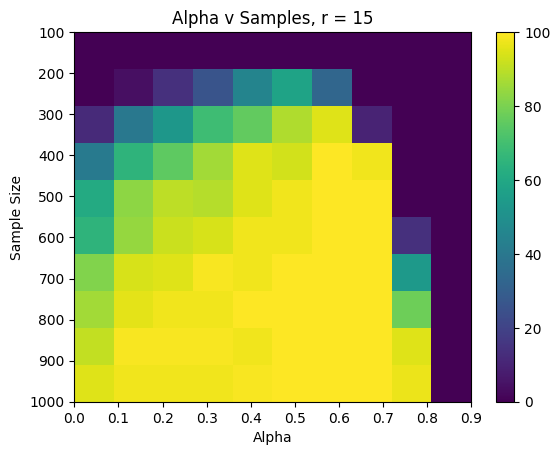

In [197]:
im = plt.imshow(convergence_r_15, extent=[alphas[0], alphas[-1], samples[-1], samples[0]], aspect='auto')
plt.colorbar()
plt.xlabel('Alpha')
plt.ylabel('Sample Size')
plt.title('Alpha v Samples, r = 15')

In [175]:
samples = np.arange(100, 1100, 100) 
alphas = np.arange(0, 10) * 0.1   

convergence_r_20 = phase_transition(samples, alphas, r = 20)
convergence_r_20

0it [00:00, ?it/s]C:\Users\gabreu\AppData\Local\Temp\ipykernel_24768\4245377890.py:34: ComplexWarning: Casting complex values to real discards the imaginary part
  x[iter] = C_inv @ x_tilde
C:\Users\gabreu\AppData\Local\Temp\ipykernel_24768\4245377890.py:34: RuntimeWarning: overflow encountered in matmul
  x[iter] = C_inv @ x_tilde
C:\Users\gabreu\AppData\Local\Temp\ipykernel_24768\4245377890.py:34: RuntimeWarning: invalid value encountered in matmul
  x[iter] = C_inv @ x_tilde
C:\Users\gabreu\AppData\Local\Temp\ipykernel_24768\4245377890.py:11: RuntimeWarning: invalid value encountered in matmul
  sorted_indices = np.argsort(np.abs(A.T @ x[iter - 1]))
C:\Users\gabreu\AppData\Local\Temp\ipykernel_24768\4245377890.py:31: RuntimeWarning: invalid value encountered in divide
  sum_gradient = A_tilde @ (np.sqrt(y_filtered) * (A_tilde.T @ x_tilde) / np.abs(A_tilde.T @ x_tilde))
C:\Users\gabreu\AppData\Local\Temp\ipykernel_24768\4245377890.py:11: RuntimeWarning: overflow encountered in matmul

array([[  0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.],
       [  1.,   6.,  11.,  24.,  38.,  56.,  68.,   0.,   0.,   0.],
       [ 14.,  41.,  57.,  65.,  76.,  87.,  98.,  45.,   0.,   0.],
       [ 38.,  63.,  77.,  84.,  91.,  92.,  97., 100.,   0.,   0.],
       [ 62.,  81.,  88.,  91.,  96.,  97.,  99., 100.,   5.,   0.],
       [ 65.,  89.,  93.,  98.,  97.,  97., 100., 100.,  58.,   0.],
       [ 74.,  93., 100.,  98., 100.,  99.,  99., 100.,  87.,   0.],
       [ 83.,  97.,  97.,  99.,  98.,  98., 100., 100.,  98.,   0.],
       [ 86.,  98.,  97.,  98.,  99., 100., 100., 100., 100.,   0.],
       [ 95.,  99.,  99., 100., 100., 100., 100., 100., 100.,   0.]])

Text(0.5, 1.0, 'Alpha v Samples, r = 20')

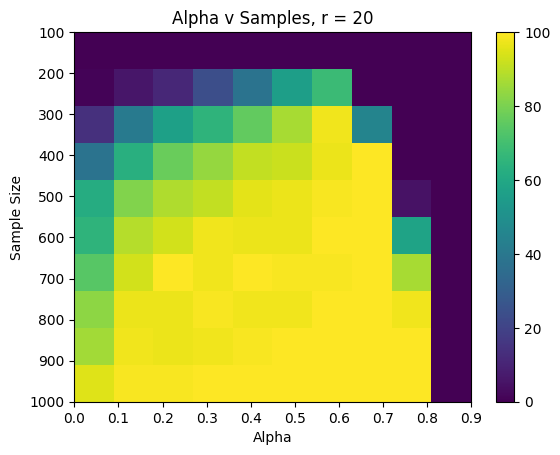

In [199]:
im = plt.imshow(convergence_r_20, extent=[alphas[0], alphas[-1], samples[-1], samples[0]], aspect='auto')
plt.colorbar()
plt.xlabel('Alpha')
plt.ylabel('Sample Size')
plt.title('Alpha v Samples, r = 20')

In [202]:
samples = np.arange(100, 1100, 100) 
alphas = np.arange(0, 10) * 0.1   
convergence_r_30 = phase_transition(samples, alphas, r = 30)
convergence_r_30

0it [00:00, ?it/s]C:\Users\gabreu\AppData\Local\Temp\ipykernel_24768\4245377890.py:34: ComplexWarning: Casting complex values to real discards the imaginary part
  x[iter] = C_inv @ x_tilde
C:\Users\gabreu\AppData\Local\Temp\ipykernel_24768\4245377890.py:34: RuntimeWarning: overflow encountered in matmul
  x[iter] = C_inv @ x_tilde
C:\Users\gabreu\AppData\Local\Temp\ipykernel_24768\4245377890.py:34: RuntimeWarning: invalid value encountered in matmul
  x[iter] = C_inv @ x_tilde
C:\Users\gabreu\AppData\Local\Temp\ipykernel_24768\4245377890.py:31: RuntimeWarning: invalid value encountered in divide
  sum_gradient = A_tilde @ (np.sqrt(y_filtered) * (A_tilde.T @ x_tilde) / np.abs(A_tilde.T @ x_tilde))
C:\Users\gabreu\AppData\Local\Temp\ipykernel_24768\4245377890.py:31: RuntimeWarning: overflow encountered in multiply
  sum_gradient = A_tilde @ (np.sqrt(y_filtered) * (A_tilde.T @ x_tilde) / np.abs(A_tilde.T @ x_tilde))
C:\Users\gabreu\AppData\Local\Temp\ipykernel_24768\4245377890.py:31: Run

array([[  0.,   0.,   0.,   0.,   2.,   0.,   0.,   0.,   0.,   0.],
       [  0.,   6.,  15.,  24.,  43.,  63.,  88.,   0.,   0.,   0.],
       [ 15.,  32.,  43.,  72.,  85.,  92.,  97., 100.,   0.,   0.],
       [ 39.,  64.,  81.,  79.,  91.,  96.,  98., 100.,   2.,   0.],
       [ 55.,  79.,  84.,  92.,  93.,  98.,  99., 100.,  83.,   0.],
       [ 72.,  88.,  89.,  96.,  98.,  99., 100., 100., 100.,   0.],
       [ 79.,  94.,  96.,  98.,  98., 100., 100., 100., 100.,   0.],
       [ 82.,  94.,  97., 100.,  99.,  99., 100., 100., 100.,   0.],
       [ 87.,  96.,  98.,  98., 100., 100.,  99., 100., 100.,   1.],
       [ 87.,  99.,  98., 100.,  99., 100., 100., 100., 100.,   2.]])

Text(0.5, 1.0, 'Alpha v Samples, r = 30')

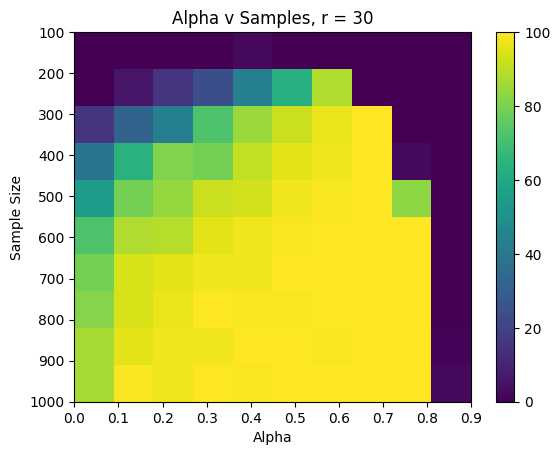

In [204]:
im = plt.imshow(convergence_r_30, extent=[alphas[0], alphas[-1], samples[-1], samples[0]], aspect='auto')
plt.colorbar()
plt.xlabel('Alpha')
plt.ylabel('Sample Size')
plt.title('Alpha v Samples, r = 30')